In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

# geometric distribution for trials prob(n) = p q^(n-1) where p is success probability
F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
# photon transmission probability in fiber (i.e., 0.2dB/km)
Trans = lambda x: 10**(-0.2*x/10)
# Binary Shanon entropy
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

# One repeater

## fixed distance, repeater location sweeping

In [2]:
def T_avg_parallel(L1,L2,Nmax=100):
    τ1 = L1/c
    τ2 = L2/c
    p1 = Trans(L1)
    p2 = Trans(L2)
    T_tot = τ1
    T_memory = 0
    Nvals = np.arange(1,Nmax)
    for i1 in range(1,Nmax):
        T_tot += np.sum(f(i1,p1)*f(Nvals,p2)*np.max(np.array([(2*i1-1)*τ1*np.ones(Nmax-1),2*Nvals*τ2]),axis=0))
    return T_tot, T_memory

def T_avg_mc(L1,L2,Nmax=10000):
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
    N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
#     N1 = F_geo(np.random.rand(Nmax),p1)
#     N2 = F_geo(np.random.rand(Nmax),p2)
#     Ts = np.max(np.array([N1*τ1,N2*τ2]),axis=0)
    Ts = np.max(np.array([N1,N2]),axis=0)
    T_tot = np.mean(Ts)
#     T_memory = 4*T_tot-(4/p1-1)*τ1-(4/p2-3)*τ2
#     T_memory_qkd = 2*T_tot-(2/p1+1)*τ1-(2/p2-2)*τ2
    f_memory = np.mean(np.exp(-(4*Ts-(4*N1-5)*τ1-(4*N2-3)*τ2)/τ_coh))
#     f_memory_qkd = np.mean(np.exp(-(2*Ts-(2*N1-1)*τ1-(2*N2-2)*τ2)/τ_coh))
#     f_memory_qkd = np.mean(np.exp(-np.abs(N1*τ1-N2*τ2)/τ_coh))
    f_memory_qkd = np.mean(np.exp(-np.abs(2*Ts*τ1-N1*τ1-N2*τ2)/τ_coh))
    return T_tot, f_memory, f_memory_qkd

def T_avg(L1,L2,Nmax=100):
    τ1 = L1/c
    τ2 = L2/c
    p1 = Trans(L1)
    p2 = Trans(L2)
    T_tot = τ1
    T_memory = 0
    for i1 in range(1,Nmax):
        for i2 in range(1,Nmax):
            T_tot += f(i1,p1)*f(i2,p2)*np.max([(2*i1-1)*τ1, 2*i2*τ2])
#             if (2*i1-1)*τ1> 2*i2*τ2:
#                 T_tot += f(i1,p1)*f(i2,p2)*(2*i1-1)*τ1
#                 T_memory += f(i1,p1)*f(i2,p2)*(4*(2*i1-1)*τ1-(4*i1-3)*τ1-(4*i2-3)*τ2)
#             else:
#                 T_tot += f(i1,p1)*f(i2,p2)*2*i2*τ2
#                 T_memory += f(i1,p1)*f(i2,p2)*(8*i2*τ2-(4*i1-3)*τ1-(4*i2-3)*τ2)
    return T_tot, T_memory


In [347]:
L0 = 200 # e2e distance [km]
c = 2e5 # speed of light [km/s]
τ_coh = 0.1

δ = 0.3
rep_loc = np.linspace(δ,1-δ,20)
inv_rate_par = np.zeros(len(rep_loc))
f_memory_par = np.zeros(len(rep_loc))
# inv_rate_mc = np.zeros(len(rep_loc))
# inv_rate_old = np.zeros(len(rep_loc))
# memory_time_old = np.zeros(len(rep_loc))
inv_rate_seq = np.zeros(len(rep_loc))
f_memory_seq = np.zeros(len(rep_loc))
for i, pos in enumerate(rep_loc):
    L1 = pos*L0
    L2 = L0 - L1
#     inv_rate_par[i], memory_time_par[i] = T_avg_parallel(L1,L2,Nmax=10000)
    inv_rate_par[i], f_memory_par[i], _ = T_avg_mc(L1,L2,Nmax=100000)
#     inv_rate_old[i], memory_time_old[i] = T_avg(L1,L2)
    inv_rate_seq[i] = 2*L1/(c*Trans(L1))+2*L2/(c*Trans(L2))
#     memory_time_seq[i] = 3*L0/c + 4*L1/(c*Trans(L1))+ 4*L2/(c*Trans(L2))
#     memory_time_seq[i] = 2*(1/Trans(L2)+1)*L2/c
        

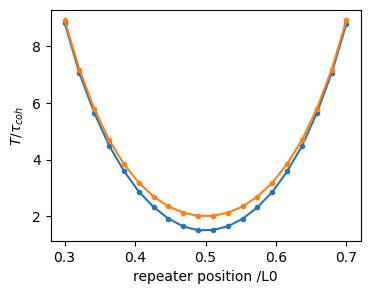

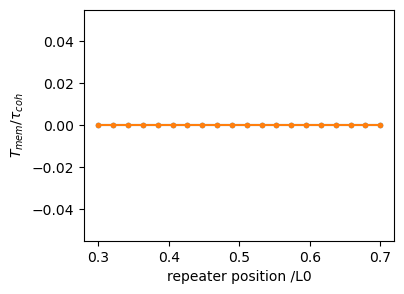

In [348]:
plt.figure(figsize=(4,3))
# plt.plot(rep_loc,inv_rate_par/τ_coh,".-")
plt.plot(rep_loc,inv_rate_par/τ_coh,".-")
plt.plot(rep_loc,inv_rate_seq/τ_coh,".-")
plt.xlabel("repeater position /L0")
plt.ylabel(r"$T/τ_{coh}$")
plt.show()

# # plt.subplot(2,1,2)
plt.figure(figsize=(4,3))
plt.plot(rep_loc,memory_time_par/τ_coh,".-")
plt.plot(rep_loc,memory_time_seq/τ_coh,".-")
plt.xlabel("repeater position /L0")
plt.ylabel(r"$T_{mem}/τ_{coh}$")
plt.show()



## rate vs. distance

In [5]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 0.05

L0_list = np.linspace(10,800,21) # e2e distance [km]
inv_rate_par = np.zeros(len(L0_list))
f_memory_par = np.zeros(len(L0_list))
f_memory_qkd_par = np.zeros(len(L0_list))
inv_rate_seq = np.zeros(len(L0_list))
f_memory_seq = np.zeros(len(L0_list))
f_memory_qkd_seq = np.zeros(len(L0_list))
for i, L0 in enumerate(L0_list):
    L1 = L0/2
    L2 = L0/2
#     inv_rate_par[i], memory_time_par[i] = T_avg_mc(L1,L2,Nmax=10000)
    inv_rate_par[i], f_memory_par[i], f_memory_qkd_par[i] = T_avg_mc(L1,L2,Nmax=100000)
    inv_rate_seq[i] = 2*L1/(c* p_link*Trans(L1))+2*L2/(c* p_link*Trans(L2))
    f_memory_seq[i] = np.exp(-3*L0/c/τ_coh) *p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-4*L2/(c*τ_coh)) )
    f_memory_qkd_seq[i] = p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-2*L2/(c*τ_coh)) )

p_list = p_link*Trans(L0_list/2)
q_list = 1- p_list
g2 = ( (1+2*q_list)*p_list*(1-q_list**2)+(1+q_list)* (q_list*(1-q_list**2)+q_list**2 *p_list) )/(1-q_list**2)**2


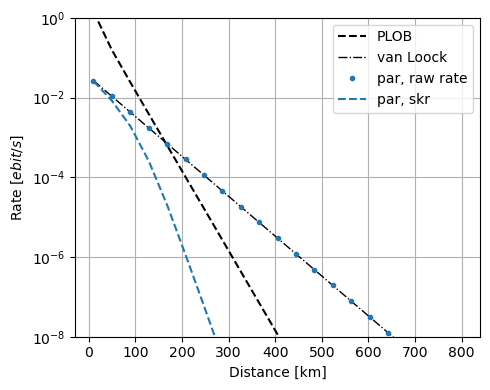

In [6]:
f_qkd_par = 0.5-0.5*f_memory_qkd_par#np.exp(-memory_time_qkd_par/τ_coh)
f_qkd_seq = 0.5-0.5*f_memory_qkd_seq#np.exp(-memory_time_qkd_seq/τ_coh)
plt.figure(figsize=(5,4))
plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,1/g2,"k-.",label="van Loock",linewidth=1)
plt.plot(L0_list,1/inv_rate_par,".",color="C0", label="par, raw rate")
plt.plot(L0_list,(1-h(f_qkd_par))/inv_rate_par,"--",color="C0", label="par, skr")
# plt.plot(L0_list,1/inv_rate_seq,"-",color="C1", label="seq, raw rate")
# plt.plot(L0_list,(1-h(f_qkd_seq))/inv_rate_seq,"--",color="C1", label="seq, skr")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
plt.ylim([1e-8,1e0])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()


# f_par = 0.5-0.5*f_memory_par#np.exp(-memory_time_par/τ_coh)
# f_seq = 0.5-0.5*f_memory_seq#np.exp(-memory_time_seq/τ_coh)
# plt.figure(figsize=(4,3))
# plt.plot(L0_list,1-f_par,"-", label="par")
# plt.plot(L0_list,1-f_seq,"-", label="seq")
# # plt.yscale("log")
# plt.xlabel("Distance [km]")
# # plt.ylabel(r"$T_{mem}/τ_{coh}$")
# plt.ylabel("Fidelity")
# plt.grid()
# plt.legend()
# plt.tight_layout()
# # plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
# plt.show()


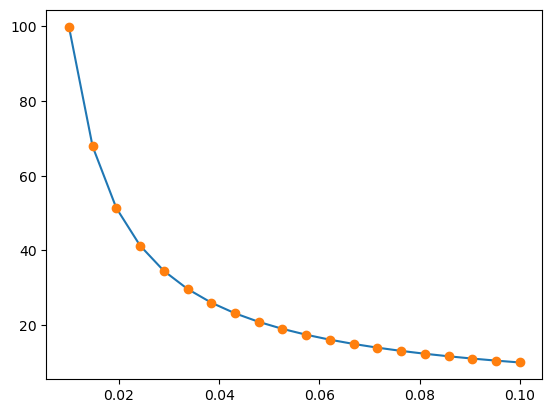

In [83]:
p_list = np.linspace(0.01,0.1,20)
Nmax = 1000
N_avg = np.zeros(len(p_list))
for i, p in enumerate(p_list):
    for i1 in range(1,Nmax):
        N_avg[i] += i1*f(i1,p)
        
plt.plot(p_list,1/p_list)
plt.plot(p_list,N_avg,"o")
plt.show()

## n repeaters

In [12]:
def T_avg_mc_n_rep(links, cct= False,Nmax=10000):
    N_links = len(links)
    τs = links/c
    Ns = np.zeros((N_links,Nmax))
    Ns[0,:] = (2*F_geo(np.random.rand(Nmax),p_link*Trans(links[0]))-1)*τs[0]
    for i in range(1,N_links):
        Ns[i,:] = 2*F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))*τs[i]
    
    Ts = np.zeros((N_links-1,Nmax))
    Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
    for i in range(1,N_links-1):
        Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
    f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
    if cct: # inclduing classical comm. 
        Tsw = np.zeros((N_links-1,Nmax))
        Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
        for i in range(1,N_links-1):
            Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]+τs[i]],axis=0)+ np.sum(τs[:(i+1)])
            
        T_tot = np.mean(np.max(Ns,axis=0))           
        Ts_A = T_tot-Ns[0,:] + τs[0] #np.zeros((1,Nmax))
        Ts_B = T_tot-Ns[-1,:] + τs[-1] #np.zeros((1,Nmax))
        f_memory = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    else:
        T_tot = np.mean(np.max(Ns,axis=0))
        Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] #np.zeros((1,Nmax))
        Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] #np.zeros((1,Nmax))
        f_memory = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))

    return T_tot, f_memory, f_memory_qkd

#     T_memory = 4*T_tot-(4/p1-3)*τ1-(4/p2-3)*τ2
#     T_memory_qkd = 2*T_tot-(2/p1-1)*τ1-(2/p2-2)*τ2


In [13]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 0.05
n = 8

L0_list = np.linspace(10,400,101) # e2e distance [km]
inv_rate_par_2 = np.zeros(len(L0_list))
f_memory_par_2 = np.zeros(len(L0_list))
f_memory_qkd_par_2 = np.zeros(len(L0_list))
inv_rate_seq_2 = np.zeros(len(L0_list))
f_memory_seq_2 = np.zeros(len(L0_list))
f_memory_qkd_seq_2 = np.zeros(len(L0_list))
for i, L0 in enumerate(L0_list):
#     L1 = L0/2
#     L2 = L0/2
    Ls = np.array([L0/n]*n)
#     inv_rate_par[i], memory_time_par[i], memory_time_qkd_par[i] = T_avg_mc(L1,L2,Nmax=100000)
    inv_rate_par_2[i],f_memory_par_2[i],f_memory_qkd_par_2[i] = T_avg_mc_n_rep(Ls,cct=True,Nmax=100000)
    inv_rate_seq_2[i] = np.sum(2*Ls/(c* p_link*Trans(Ls)))
#     memory_time_seq_2[i] = 3*L0/c + 4*np.sum(2*Ls[1:]/(c* p_link*Trans(Ls[1:])))
#     memory_time_qkd_seq[i] = 2*(1/(p_link*Trans(L2))+1)*L2/c
    f_memory_seq_2[i] = np.exp(-3*L0/c/τ_coh) *np.prod(p_link*Trans(Ls[1:])*np.exp(-4*Ls[1:]/(c*τ_coh))/(1- (1-p_link*Trans(Ls[1:]))*np.exp(-4*Ls[1:]/(c*τ_coh)) ) )
    f_memory_qkd_seq_2[i] = np.prod( p_link*Trans(Ls[1:])*np.exp(-4*Ls[1:]/(c*τ_coh))/(1- (1-p_link*Trans(Ls[1:]))*np.exp(-2*Ls[1:]/(c*τ_coh)) )  )


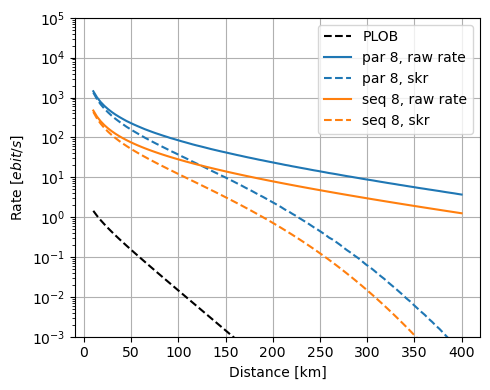

In [14]:
f_qkd_par_2 = 0.5-0.5*f_memory_qkd_par_2#np.exp(-memory_time_qkd_par/τ_coh)
f_qkd_seq_2 = 0.5-0.5*f_memory_qkd_seq_2#np.exp(-memory_time_qkd_seq/τ_coh)
plt.figure(figsize=(5,4))
plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,1/inv_rate_par_2,"-",color="C0", label="par %d, raw rate" % n)
# plt.plot(L0_list,1/inv_rate_par,"-",color="C1", label="par, raw rate")
plt.plot(L0_list,(1-h(f_qkd_par_2))/inv_rate_par_2,"--",color="C0", label="par %d, skr" % n)
# plt.plot(L0_list,(1-h(f_qkd_par))/inv_rate_par,"--",color="C1", label="par, skr")
plt.plot(L0_list,1/inv_rate_seq_2,"-",color="C1", label="seq %d, raw rate" % n)
plt.plot(L0_list,(1-h(f_qkd_seq_2))/inv_rate_seq_2,"--",color="C1", label="seq %d, skr" % n)
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
plt.ylim([1e-3,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()


# f_par_2 = 0.5-0.5*f_memory_par_2#np.exp(-memory_time_par/τ_coh)
# # f_seq = 0.5-0.5*f_memory_seq#np.exp(-memory_time_seq/τ_coh)
# plt.figure(figsize=(4,3))
# plt.plot(L0_list,1-f_par_2,"-", label="par")
# plt.plot(L0_list,1-f_par,"-", label="par %d" % n)
# # plt.plot(L0_list,1-f_seq,"-", label="seq")
# # plt.yscale("log")
# plt.xlabel("Distance [km]")
# # plt.ylabel(r"$T_{mem}/τ_{coh}$")
# plt.ylabel("Fidelity")
# plt.grid()
# plt.legend()
# plt.tight_layout()
# # plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
# plt.show()


## cutoff

In [40]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 0.7 # photon insertion loss incorporates various efficiencies of the experimental hardware

def T_sequential_no_cutoff(τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    T_tot = 2* np.sum( τs / (p_link*Trans(links)) )

    raw_rate = 2*τs[0]/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    # f_memory_qkd = np.prod( p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_memory_qkd = np.prod( p_link*Trans(links[1:])*np.exp(-τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod(p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) ) )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    return raw_rate, skr, F_e2e

def T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    # implementing the recursion relation :
    ### Tn = Tn-1 / Pn + ( (1/Pn -1) τ_cut + Nm(ms[n],ps[n])*2*τs[n]/Pn)
    p1 = p_link*Trans(links[0])
    T_tot = 2*τs[0]/p1
    for i_l in np.arange(1,len(links)):
        L = links[i_l]
        m_n = int(τ_cut/(2*τs[i_l]))
        p_n = p_link*Trans(L)
        Nm = lambda x: (1-(1+m_n*x)*(1-x)**m_n)/x
        Pm = 1- (1-p_n)**m_n
        T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm

    raw_rate = 2*τs[0]/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    m_arr = np.floor(τ_cut/(2*τs))
    Pm_arr = 1- (1-p_link*Trans(links))**m_arr
    # f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-4*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) )  )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    # skr, F_e2e = 0, 0
    return raw_rate, skr, F_e2e



In [43]:
n = 4 # number of segments (i.e., no. of repeaters -1 )
τ_coh = 0.1
# τ_cut = 150*τ_coh # cutoff
F_link = 1 # fidelity of local BP
mu_link = 1.0 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

Le2e_list = np.linspace(10,1000,101) # e2e distance [km]
raw_rate_seq = np.zeros(len(Le2e_list))
skr_seq = np.zeros(len(Le2e_list))
Fe2e_seq = np.zeros(len(Le2e_list))
raw_rate_seq_no_cutoff = np.zeros(len(Le2e_list))
skr_seq_no_cutoff = np.zeros(len(Le2e_list))
Fe2e_seq_no_cutoff = np.zeros(len(Le2e_list))

for i, Le2e in enumerate(Le2e_list):
    Ls = [Le2e/n]*n
    τ_cut = 150*Ls[0]/c # cutoff
    raw_rate_seq[i], skr_seq[i], Fe2e_seq[i] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
    raw_rate_seq_no_cutoff[i], skr_seq_no_cutoff[i], Fe2e_seq_no_cutoff[i] = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)


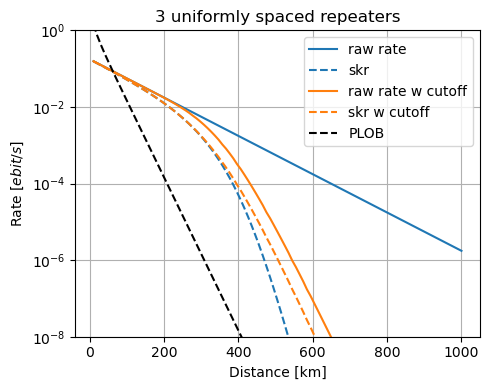

In [44]:
plt.figure(figsize=(5,4))
# plt.plot(Le2e_list,-np.log2(1-Trans(Le2e_list)),"k--", label="PLOB")
plt.plot(Le2e_list,raw_rate_seq_no_cutoff,"-",color="C0", label="raw rate")
plt.plot(Le2e_list,skr_seq_no_cutoff,"--",color="C0", label="skr")
plt.plot(Le2e_list,raw_rate_seq,"-",color="C1", label="raw rate w cutoff")
plt.plot(Le2e_list,skr_seq,"--",color="C1", label="skr w cutoff")
plt.plot(Le2e_list,-np.log2(1-Trans(Le2e_list)),"k--", label="PLOB")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
plt.ylim([1e-8,1e0])
plt.title(f"{n-1} uniformly spaced repeaters")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("figs/7_qr_cutoff_effect.pdf")
plt.show()


# plt.figure(figsize=(5,4))
# plt.plot(Le2e_list,Fe2e_seq,"-", label="seq")
# plt.title(f"{n-1} uniformly spaced repeaters")
# # plt.yscale("log")
# plt.xlabel("Distance [km]")
# # plt.ylabel(r"$T_{mem}/τ_{coh}$")
# plt.ylabel("Fidelity")
# plt.grid()
# plt.legend()
# plt.tight_layout()
# # plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
# plt.show()


In [ ]:
|